## Introduction

Context
This dataset contains 4242 images of flowers.
The data collection is based on the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

Content
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

In this notebook, I'll use pytorch library to create a convolutional network, so that we can train a model which can help us classify images into their types.


# Data Overview

In [1]:
dataset_url = "https://www.kaggle.com/alxmamaev/flowers-recognition"

In [2]:
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [3]:
dataset = ImageFolder('~/Desktop/flowers')

In [4]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [5]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7FEE990B6C40>, 0)

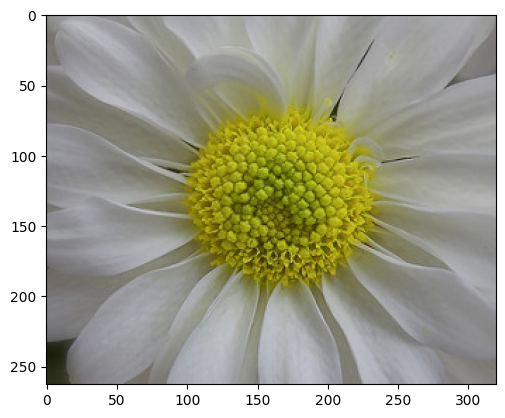

In [6]:
img, label = dataset[0]
plt.imshow(img)

In [7]:
import torchvision.transforms as tt
# now we will load the dataset again, and transform the images to tensors
# loaded images are in different size, so we will resize all of them to the same size, because we need same size for our neural network
dataset = ImageFolder('~/Desktop/flowers', tt.Compose([tt.Resize(64), 
                                                       tt.RandomCrop(64),
                                                       tt.ToTensor()
                                                       ]))

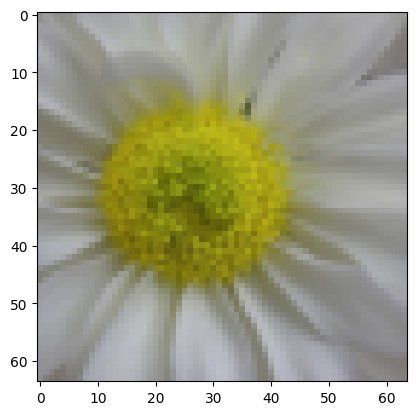

In [8]:
img, label = dataset[0]
plt.imshow(img.permute(1,2,0))

### Split the dataset into validation and training

In [9]:
validation_size = int(0.1 * len(dataset))
train_size = int(len(dataset)) - validation_size

train_size, validation_size

(3886, 431)

In [10]:
from torch.utils.data import random_split
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

Now we will load the data in batches, so that we can train the model in batches, num_workers parameter is for parallel processing

Shuffle is true on training data, so that the model does not learn the order of the images

For validation there's no need of shuffling.

Batch is a small selection of images taken from the dataset, which is used to train the model in each iteration.

In each iteration we have a different batch of images, so that the model can learn from different images in each iteration.

In [11]:
from torch.utils.data import DataLoader
batch_size = 256

train_data_batched = DataLoader(train_dataset, batch_size, shuffle=True, num_workers = 4,pin_memory=True)

validation_data_batched = DataLoader(validation_dataset, batch_size, num_workers = 4,pin_memory=True)

In [12]:
train_data_batched

In [13]:
import numpy as np

# Count the number of instances for each class
unique, counts = np.unique(dataset.targets, return_counts=True)

# Print the number of instances for each class
for u, c in zip(unique, counts):
    print(f"Class {dataset.classes[u]}: {c} instances")

Class daisy: 764 instances
Class dandelion: 1052 instances
Class rose: 784 instances
Class sunflower: 733 instances
Class tulip: 984 instances


The balanced looks balanced, we won't apply any techniques to balance the dataset.

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

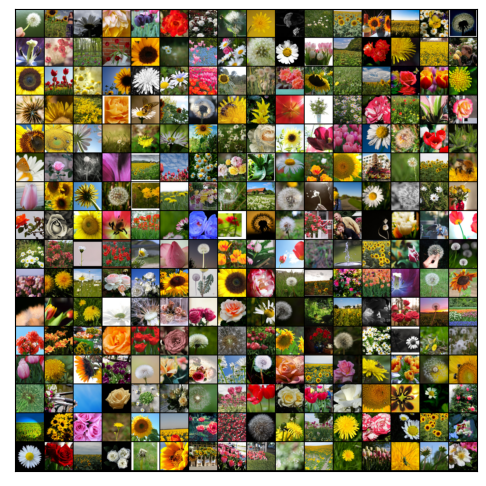

In [15]:
show_batch(train_data_batched)

## Model and Training

A general framework for image classification, depending on the problem, different loss function metrics can be used, also different techniques of computing gradients can be applied.

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch
class ImageClassificationBase(nn.Module):
    def forward_and_compute_loss(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        return out, loss

    def training_step(self, batch):
        _, loss = self.forward_and_compute_loss(batch)
        return loss
    
    def validation_step(self, batch):
        out, loss = self.forward_and_compute_loss(batch)
        acc = self.accuracy(out, batch[1])    # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        epoch_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        epoch_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
        
    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))
        

## Evaluating and training (fit method)

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

We could either create our own model (initialize a convolutional neural network from scratch), define the layers of our neural netowrk, or use existing models

RESNET9 Model

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [19]:
model = ResNet9(3, len(dataset.classes))

In [20]:
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [21]:
history = [evaluate(model, validation_data_batched)]
history

[{'val_loss': 1.6093363761901855, 'val_acc': 0.22290179133415222}]

This is the evaluation of the base model, now we will train it, such that it can learn how to classify the flowers based on the training set

## Training and Evaluation

In [23]:
history += fit(3, 0.1, model, train_data_batched, validation_data_batched, torch.optim.Adam)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [ ]:
plot_losses(history)

## Testing w/ individual images

After we trained our model, now we can make a prediction on a new unseen flower image, and we will get it's class in which that flower belongs to.

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)